# Скоринговая модель

In [82]:
import os
import re
import string
import traceback
import numpy
from collections import Counter, defaultdict
from functools import reduce

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas.core.algorithms as algos
import scipy.stats.stats as stats
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.svm import LinearSVC
from imblearn.under_sampling import ClusterCentroids, RandomUnderSampler
from pandas import DataFrame, Series
from sklearn import metrics, preprocessing
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import RFE, SelectFromModel, SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score,
roc_auc_score, roc_curve)
from sklearn.metrics._plot.confusion_matrix import confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

# 1. Обработка данных

In [30]:
df = pd.read_excel('scoring_2.xlsx', sheet_name='Лист2') #Read excel file
df = df.dropna()
df = df.drop(columns = ['birth_date','date_beggining', 'date_end'])

In [31]:
df.info()
df.head()
df['car_age'] = df['car_age'].astype(np.int64)
df['loss'] = df['loss'].astype(np.int64)
df['premium'] = df['premium'].astype(np.int64)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16339 entries, 0 to 16371
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SEX           16339 non-null  object 
 1   day_birth     16339 non-null  object 
 2   month_birth   16339 non-null  object 
 3   age           16339 non-null  int64  
 4   experience    16339 non-null  int64  
 5   month_happen  16339 non-null  object 
 6   day_happen    16339 non-null  object 
 7   car_age       16339 non-null  float64
 8   loss          16339 non-null  float64
 9   safe          16339 non-null  int64  
 10  premium       16339 non-null  float64
 11  model         16339 non-null  object 
 12  y             16339 non-null  int64  
dtypes: float64(3), int64(4), object(6)
memory usage: 1.7+ MB


In [32]:
# Convert the string variable into numerical representation using TfidfVectorizer
vectorizer = TfidfVectorizer()
cc_model = vectorizer.fit_transform(df["model"])

# Perform cluster analysis using KMeans
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(cc_model)

# Assign the cluster labels to the original data
df["cluster_labels"] = kmeans.labels_

# View the cluster labels for each data point
print(df[["model", "cluster_labels"]])

                     model  cluster_labels
0              Honda CIVIC               2
1                ВАЗ 21110               0
2                ВАЗ 21110               0
3         Chery Tiggo(T11)               0
4       Mercedes-Benz E240               0
...                    ...             ...
16367           Opel ASTRA               0
16368  Renault SYMBOL EX14               0
16369         TOYOTA CAMRY               0
16370         TOYOTA CAMRY               0
16371          Kia Spectra               0

[16339 rows x 2 columns]


Сделаем дамми переменные

In [33]:
# Convert the cluster_labels variable into a one-hot encoded representation
cluster_labels_dummies = pd.get_dummies(df["cluster_labels"], prefix="cluster")

# Concatenate the original data frame with the one-hot encoded representation
df = pd.concat([df, cluster_labels_dummies], axis=1)

In [34]:
# Data transformation
# Convert categorical values to numeric using label encoder
d = defaultdict(preprocessing.LabelEncoder)
# Encoding the categorical variable
fit = df.select_dtypes(include=['object']).apply(lambda x: d[x.name].fit_transform(x))

#Convert the categorical columns based on encoding
for i in list(d.keys()):
    df[i] = d[i].transform(df[i])

In [61]:
df = df.drop(columns=['model', 'cluster_labels'])

In [62]:
features = df[df.columns.difference(['y'])]
labels = df['y']

# 2. Variable Selection
2.1 Weight of Evidence and Information Value

In [63]:
max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv) 

final_iv, IV = data_vars(df,df.y)
IV = IV.rename(columns={'VAR_NAME':'index'})
IV.sort_values(['IV'],ascending=0)
df.describe()

,SEX,day_birth,month_birth,age,experience,month_happen,day_happen,car_age,loss,safe,premium,y,cluster_0,cluster_1,cluster_2
count,16339.00,16339.00,16339.00,16339.00,16339.00,16339.00,16339.00,16339.00,16339.00,16339.00,16339.00,16339.00,16339.00,16339.00,16339.00
mean,0.84,2.99,5.64,42.67,24.27,5.66,3.14,4.89,25780.33,399706.22,4192.18,0.70,0.91,0.04,0.05
std,0.36,2.00,3.53,9.70,7.33,3.43,1.94,16.42,28627.66,7811.71,1607.36,0.46,0.29,0.21,0.21
min,0.00,0.00,0.00,26.00,17.00,0.00,0.00,0.00,0.00,160000.00,273.00,0.00,0.00,0.00,0.00
25%,1.00,1.00,3.00,34.00,18.00,3.00,1.00,1.00,7126.00,400000.00,3063.00,0.00,1.00,0.00,0.00
50%,1.00,3.00,6.00,41.00,22.00,6.00,3.00,3.00,15593.00,400000.00,4039.00,1.00,1.00,0.00,0.00
75%,1.00,5.00,9.00,50.00,28.00,9.00,5.00,7.00,32730.50,400000.00,5149.00,1.00,1.00,0.00,0.00
max,1.00,6.00,11.00,89.00,69.00,11.00,6.00,2011.00,240000.00,400000.00,11880.00,1.00,1.00,1.00,1.00


In [89]:
IV.sort_values(['IV'],ascending=0)

,index,IV
9,loss,0.90
12,premium,0.00
10,month_birth,0.00
0,SEX,0.00
8,experience,0.00
1,age,0.00
6,day_birth,0.00
5,cluster_2,0.00
2,car_age,0.00
7,day_happen,0.00


3.2 Variable Importance

In [64]:
clf = RandomForestClassifier()

clf.fit(features,labels)

preds = clf.predict(features)

accuracy = accuracy_score(preds,labels)
print(accuracy)

1.0


In [65]:
VI = DataFrame(clf.feature_importances_, columns = ["RF"], index=features.columns)
VI = VI.reset_index()
VI.sort_values(['RF'],ascending=0)

,index,RF
9,loss,0.97
12,premium,0.01
1,age,0.00
2,car_age,0.00
8,experience,0.00
11,month_happen,0.00
10,month_birth,0.00
7,day_happen,0.00
6,day_birth,0.00
0,SEX,0.00


3.3 Recursive Feature Elimination

In [66]:
model = LogisticRegression()

rfe = RFE(model, step=20)
fit = rfe.fit(features, labels)
Selected = DataFrame(rfe.support_, columns = ["RFE"], index=features.columns)
Selected = Selected.reset_index()
Selected[Selected['RFE'] == True]

,index,RFE
1,age,True
2,car_age,True
6,day_birth,True
8,experience,True
9,loss,True
10,month_birth,True
11,month_happen,True


3.4 Variable Importance - Extratrees Classifier

In [67]:
model = ExtraTreesClassifier()
model.fit(features, labels)
print(model.feature_importances_)

[0.00374397 0.03091565 0.02811903 0.00193874 0.00136513 0.00132042
 0.02138988 0.0211241  0.02849106 0.77956255 0.0242262  0.02564398
 0.03186618 0.00029312]


In [68]:
FI = DataFrame(model.feature_importances_, columns = ["Extratrees"], index=features.columns)
FI = FI.reset_index()
FI.sort_values(['Extratrees'],ascending=0)

,index,Extratrees
9,loss,0.78
12,premium,0.03
1,age,0.03
8,experience,0.03
2,car_age,0.03
11,month_happen,0.03
10,month_birth,0.02
6,day_birth,0.02
7,day_happen,0.02
0,SEX,0.00


3.5 Chi Square

In [69]:
df1 = df.copy()
d = defaultdict(preprocessing.LabelEncoder)
# Encoding the categorical variable
fit = df1.apply(lambda x: d[x.name].fit_transform(x))

#Convert the categorical columns based on encoding
for i in list(d.keys()):
    df1[i] = d[i].transform(df1[i])

In [70]:
features1 = df1[df1.columns.difference(['y'])]
labels1 = df1['y']

In [71]:
model_1 = SelectKBest(score_func=chi2, k=5)
fit = model_1.fit(features1, labels1)
numpy.set_printoptions(suppress=True)
print(fit.scores_)

[       0.20130267        2.72010455        1.81032565        0.0006088
        0.18415194        0.27639866        0.03098448        2.6553188
        0.38252376 29104924.13554844        1.42085113        0.11456852
      255.25370336        0.01136801]


In [72]:
pd.options.display.float_format = '{:.2f}'.format
chi_sq = DataFrame(fit.scores_, columns = ["Chi_Square"], index=features1.columns)
chi_sq = chi_sq.reset_index()
chi_sq.sort_values('Chi_Square',ascending=0)

,index,Chi_Square
9,loss,29104924.14
12,premium,255.25
1,age,2.72
7,day_happen,2.66
2,car_age,1.81
10,month_birth,1.42
8,experience,0.38
5,cluster_2,0.28
0,SEX,0.20
4,cluster_1,0.18


3.6 L1 feature selection

In [73]:
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(features, labels)
model = SelectFromModel(lsvc,prefit=True)
l1 = DataFrame(model.get_support(), columns = ["L1"], index=features.columns)
l1 = l1.reset_index()
l1[l1['L1'] == True]

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,index,L1
1,age,True
2,car_age,True
6,day_birth,True
7,day_happen,True
8,experience,True
9,loss,True
10,month_birth,True
11,month_happen,True
12,premium,True
13,safe,True


3.7 Combine all together

In [74]:
dfs = [IV, VI, Selected, FI, chi_sq, l1]
final_results = reduce(lambda left,right: pd.merge(left,right,on='index'), dfs)
final_results.head()

,index,IV,RF,RFE,Extratrees,Chi_Square,L1
0,SEX,0.00,0.00,False,0.00,0.20,False
1,age,0.00,0.00,True,0.03,2.72,True
2,car_age,0.00,0.00,True,0.03,1.81,True
3,cluster_0,0.00,0.00,False,0.00,0.00,False
4,cluster_1,0.00,0.00,False,0.00,0.18,False


3.8 Variable Score

In [75]:
final_results.columns

Index(['index', 'IV', 'RF', 'RFE', 'Extratrees', 'Chi_Square', 'L1'], dtype='object')

In [76]:
columns = ['IV', 'RF', 'Extratrees', 'Chi_Square']

score_table = pd.DataFrame({},[])
score_table['index'] = final_results['index']

for i in columns:
    score_table[i] = final_results['index'].isin(list(final_results.nlargest(5,i)['index'])).astype(int)
    
score_table['RFE'] = final_results['RFE'].astype(int)
score_table['L1'] = final_results['L1'].astype(int)

In [77]:
score_table['final_score'] = score_table.sum(axis=1)
score_table.sort_values('final_score',ascending=0)

<ipython-input-77-7501be611551>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  score_table['final_score'] = score_table.sum(axis=1)


,index,IV,RF,Extratrees,Chi_Square,RFE,L1,final_score
9,loss,1,1,1,1,1,1,6
1,age,0,1,1,1,1,1,5
2,car_age,0,1,1,1,1,1,5
8,experience,1,1,1,0,1,1,5
12,premium,1,1,1,1,0,1,5
10,month_birth,1,0,0,0,1,1,3
6,day_birth,0,0,0,0,1,1,2
7,day_happen,0,0,0,1,0,1,2
11,month_happen,0,0,0,0,1,1,2
0,SEX,1,0,0,0,0,0,1


3.9 Multicollinearity - VIF (Addon)

In [78]:
def calculate_vif(features):
    vif = pd.DataFrame()
    vif["Features"] = features.columns
    vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]    
    return(vif)

In [79]:
vif = calculate_vif(features)
while vif['VIF'][vif['VIF'] > 10].any():
    remove = vif.sort_values('VIF',ascending=0)['Features'][:1]
    features.drop(remove,axis=1,inplace=True)
    vif = calculate_vif(features)
vif

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Features,VIF
0,SEX,5.08
1,car_age,1.10
2,cluster_1,1.05
3,cluster_2,1.07
4,day_birth,3.07
5,day_happen,3.37
6,experience,8.02
7,loss,1.79
8,month_birth,3.34
9,month_happen,3.44


Logistic Regression with SMOTE oversampling

In [86]:
y = df['y']
X = df.drop(columns = ['y', 'safe'], axis=1)

In [87]:
# Load the data and split into train and test sets
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.2, random_state=0)

# Resample the minority class using SMOTE
sm = SMOTE(sampling_strategy='minority', random_state=0)
X_train_2, y_train_2 = sm.fit_resample(X_train_2, y_train_2)

# Train a logistic regression model on the resampled training set
model = LogisticRegression(C=0.00001, max_iter=18)
model.fit(X_train_2, y_train_2)

# Predict on the test set
y_pred_22 = model.predict(X_test_2)

# Confusion matrix
cm = confusion_matrix(y_test_2, y_pred_22)
print('Confusion Matrix: \n', cm)

# Performance metrics
acc = accuracy_score(y_test_2, y_pred_22)
prec = precision_score(y_test_2, y_pred_22)
rec = recall_score(y_test_2, y_pred_22)
f1 = f1_score(y_test_2, y_pred_22)

print('Accuracy:', acc)
print('Precision:', prec)
print('Recall:', rec)
print('F1-score:', f1)

Confusion Matrix: 
 [[ 926   66]
 [ 283 1993]]
Accuracy: 0.8932068543451652
Precision: 0.9679456046624575
Recall: 0.8756590509666081
F1-score: 0.9194925028835064


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


roc_auc_score for Logistic Regression:  0.9713711449061738


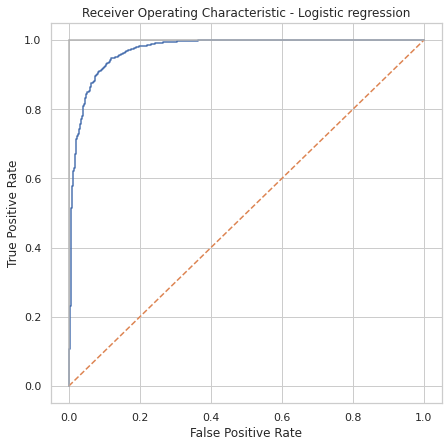

In [88]:
# ROC curve
y_score = model.predict_proba(X_test_2)[:, 1]
fpr, tpr, _ = roc_curve(y_test_2, y_score)
roc_auc = roc_auc_score(y_test_2, y_score)

false_positive_rate, true_positive_rate, threshold = roc_curve(y_test_2, y_score)
print('roc_auc_score for Logistic Regression: ', roc_auc_score(y_test_2, y_score))
plt.subplots(1, figsize=(7,7))
plt.title('Receiver Operating Characteristic - Logistic regression')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()